In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# img normalization
from torchvision import transforms
from pytorch3d.transforms import axis_angle_to_matrix
from pytorch3d.ops import taubin_smoothing, cubify


import os
import sys
sys.path.append(os.path.abspath('..'))

from ops.medical_related import get_4chamberview_frame 

import numpy as np
import nibabel as nib

from torch_scatter import scatter

import pyvista as pv
pv.start_xvfb(wait=0)
pv.set_jupyter_backend('html')

from einops import rearrange, repeat

import data.data_utils as dut
from data.dataset import *

import matplotlib.pyplot as plt

import trimesh
from pytorch3d.io import save_obj, load_objs_as_meshes
from pytorch3d.transforms import axis_angle_to_matrix, matrix_to_axis_angle



In [2]:
dataset = MMWHSDataset_3DLabel(dataset_path='../../../Dataset/MMWHS', mode='train', modality='mixed',
                               output_shape=(256,256,256),
                                RML_simple = True)

dataset = ACDCDataset_3DLabel(dataset_path='../../../Dataset/ACDC', mode='train', output_shape=None)

Loading data from:  ../../../Dataset/ACDC/database/training/
Total number of loaded data:  200


In [11]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=0)

query_num = 1000

device = torch.device('cuda:0')


for i, example in enumerate(dataloader):

    image_tem = example['image'].to(device)
    affine_tem = example['affine'].to(device)
    label_tem = example['label'].to(device)


    recubified = cubify((label_tem==dataset.label_value[2]).squeeze(1).float(), 0.48)
    

    B = image_tem.shape[0]

    ## -------------- Data augmentation -----------------##

    coordinate_map_tem = dut.get_coord_map_3d_normalized(image_tem.shape[-3:], affine_tem)

    

    lv_cavity_index =  torch.where(label_tem==2)
    lv_cavity_center = coordinate_map_tem[lv_cavity_index[0],lv_cavity_index[2],lv_cavity_index[3],lv_cavity_index[4],:]
    lv_cavity_center = scatter(lv_cavity_center, lv_cavity_index[0], dim=0, reduce='mean')

    

    affine_aug_2d  = dut.random_affine(B=B, dim=2, rot_range=[-np.pi, np.pi], 
                                    scale_range=[1.,1.], trans_range=[-0.2,0.2]).to(device)
    
    affine_aug = torch.eye(4).to(device).unsqueeze(0).repeat(B,1,1)
    affine_aug[...,:2,:2] = affine_aug_2d[...,:2,:2]
    affine_aug[...,:2, 3] = affine_aug_2d[...,:2, 2]
    
    
    affine_aug[...,:3, 3] = affine_aug[...,:3, 3] + lv_cavity_center 

    del lv_cavity_center, lv_cavity_index

    Z_new, Y_new, X_new = 8, 128, 128

    # Z_new = np.random.randint(32, 64)

    with torch.no_grad():
        new_affine = affine_tem.inverse()@affine_aug

        new_affine_inv = new_affine.inverse()

        recubified = recubified.update_padded(recubified.verts_padded().matmul(new_affine_inv[..., :3,:3].transpose(-1,-2))+new_affine_inv[...,:3,3].unsqueeze(-2))

        label_tem = dut.augment_from_affine(label_tem, new_affine, (Z_new, Y_new, X_new), mode='nearest')
        image_tem = dut.augment_from_affine(image_tem, new_affine, (Z_new, Y_new, X_new), mode='bilinear')

        example['label'] = label_tem
        example['image'] = image_tem
        
        coordinate_map_tem = dut.get_coord_map_3d_normalized(image_tem.shape[-3:], torch.eye(4).to(device).unsqueeze(0).repeat(B,1,1))
        
        B, C, Z, Y, X = image_tem.shape


        query_points_labeled = rearrange(coordinate_map_tem, 
                                            'b z y x c -> b (z y x) c', c=3)
        query_points_labeled = torch.cat([query_points_labeled, 
                                        rearrange(label_tem==dataset.label_value[2], 'b 1 z y x -> b (z y x) 1')], dim=-1)
        
        query_points_list = []
        target_affine_list = []

        



        for b in range(B):
            Z_rv, Y_rv, X_rv = torch.where(label_tem[b, 0]==dataset.label_value[1])
            Z_lv, Y_lv, X_lv = torch.where(label_tem[b, 0]==dataset.label_value[2])
            Z_cav, Y_cav, X_cav = torch.where(label_tem[b, 0]==dataset.label_value[3])
            Z_bg, Y_bg, X_bg = torch.where(label_tem[b, 0]==dataset.label_value[0])
            
            Pt_rv = coordinate_map_tem[b, Z_rv, Y_rv, X_rv]
            Pt_lv = coordinate_map_tem[b, Z_lv, Y_lv, X_lv]
            Pt_cav = coordinate_map_tem[b, Z_cav, Y_cav, X_cav]

            geom_dict = get_4chamberview_frame(Pt_cav, Pt_lv, Pt_rv)
            target_affine_list.append(geom_dict['target_affine'])

            # select the query points
            query_points_index_0 = torch.where(((query_points_labeled[b,:,:3]).abs().max(dim=-1).values < 1.0) & (query_points_labeled[b,:,3] < 0.5))[0]
            query_points_index_1 = torch.where(((query_points_labeled[b,:,:3]).abs().max(dim=-1).values < 1.0) & (query_points_labeled[b,:,3] > 0.5))[0]
            query_points_index_0 = query_points_index_0[np.random.choice(query_points_index_0.shape[0], query_num//2, replace=True)]
            query_points_index_1 = query_points_index_1[np.random.choice(query_points_index_1.shape[0], query_num//2, replace=True)]
            query_points_index = torch.cat([query_points_index_0, query_points_index_1], dim=0)
            query_points_list.append(query_points_labeled[b: b+1, query_points_index])

        query_points_labeled = torch.cat(query_points_list, dim=0)
        target_affine = torch.stack(target_affine_list, dim=0)

        break





/home/yihao/anaconda3/envs/MedicalImage/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/yihao/anaconda3/envs/MedicalImage/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [12]:
bi_ventricle_trimesh = trimesh.load_mesh('../canonical_shapes/Standard_BiV.obj')
lv_trimesh = trimesh.load_mesh('../canonical_shapes/Standard_LV_2000.obj')

b = np.random.randint(0, B)

lv_trimesh = lv_trimesh.apply_transform(target_affine[b].detach().cpu().numpy())

recubified_trimesh = trimesh.Trimesh(vertices=recubified.verts_list()[b].detach().cpu().numpy(), 
                                     faces=recubified.faces_list()[b].detach().cpu().numpy())



coordinate_map_np = coordinate_map_tem[b].detach().cpu().numpy()

pl = pv.Plotter(notebook=True)
interval = 1
if image_tem.shape[-3] > 20:
    interval = 2
if image_tem.shape[-3] > 256:
    interval = 2
for i in range(0, image_tem.shape[-3], interval):

    x, y, z = coordinate_map_np[i,...,0], coordinate_map_np[i,...,1], coordinate_map_np[i,...,2]

    grid = pv.StructuredGrid(x, y, z)

    color_gt = (label_tem[b,0,i].cpu().numpy().T.flatten() ==2).astype(np.float32)
    raw_image = image_tem[b,0,i].cpu().numpy().T.flatten()
    color_opacity = np.ones_like(color_gt)*0.4

    color_opacity[color_gt == 0] = 0.05

    pl.add_mesh(grid, scalars = color_gt, cmap = 'Accent_r',
                show_scalar_bar = False, opacity = color_opacity, clim=[0,3])
    
    

pl.add_mesh(lv_trimesh, color='blue', opacity=0.1)

# # pl.add_mesh(bi_ventricle_trimesh_target, color='red', opacity=0.1)
# pl.add_mesh(lv_trimesh_target, color='blue', opacity=0.2, show_edges=True, show_vertices=True)
# pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')

# pl.add_points(Pt_center.cpu().numpy(), color='red', point_size=10)
# pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(u2d_axis).cpu().numpy(), color='blue') 
# pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(l2r_axis).cpu().numpy(), color='green')
# pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(b2f_axis).cpu().numpy(), color='red')
pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')


pl.add_mesh(recubified_trimesh, color='red', opacity=0.1)


# pl.add_points(lv_cavity_center.cpu().numpy(), color='red', point_size=10)

pl.add_axes()
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [36]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=8)

query_num = 1000

device = torch.device('cuda:1')

for i, example in enumerate(dataloader):

    image_tem = example['image'].to(device)
    affine_tem = example['affine'].to(device)
    label_tem = example['label'].to(device)

    B = image_tem.shape[0]



    coordinate_map_tem = dut.get_coord_map_3d_normalized(image_tem.shape[-3:], affine_tem)

    lv_cavity_index =  torch.where(label_tem==2)
    lv_cavity_center = coordinate_map_tem[lv_cavity_index[0],lv_cavity_index[2],lv_cavity_index[3],lv_cavity_index[4],:]
    lv_cavity_center = scatter(lv_cavity_center, lv_cavity_index[0], dim=0, reduce='mean')

    

    affine_aug  = dut.random_affine(B=B, dim=3, rot_range=[-np.pi, np.pi], 
                                    scale_range=[1.,1.], trans_range=[-0.2,0.2]).to(device)
    
    affine_aug[...,:3, 3] = affine_aug[...,:3, 3] + lv_cavity_center 

    Z_new, Y_new, X_new = 128, 128, 128

    Z_new = np.random.randint(64, 128)

    new_affine = affine_tem.inverse()@affine_aug

    label_tem = dut.augment_from_affine(label_tem, new_affine, (Z_new, Y_new, X_new), mode='nearest')
    image_tem = dut.augment_from_affine(image_tem, new_affine, (Z_new, Y_new, X_new), mode='bilinear')
    
    coordinate_map_tem = dut.get_coord_map_3d_normalized(image_tem.shape[-3:], torch.eye(4).to(device).unsqueeze(0).repeat(B,1,1))
    
    B, C, Z, Y, X = image_tem.shape


    query_points_labeled = rearrange(coordinate_map_tem, 
                                        'b z y x c -> b (z y x) c', c=3)
    query_points_labeled = torch.cat([query_points_labeled, 
                                    rearrange(label_tem==dataset.label_value[2], 'b 1 z y x -> b (z y x) 1')], dim=-1)
    
    query_points_list = []
    target_affine_list = []
    

    for b in range(B):
        Z_rv, Y_rv, X_rv = torch.where(label_tem[b, 0]==dataset.label_value[1])
        Z_lv, Y_lv, X_lv = torch.where(label_tem[b, 0]==dataset.label_value[2])
        Z_cav, Y_cav, X_cav = torch.where(label_tem[b, 0]==dataset.label_value[3])
        Z_bg, Y_bg, X_bg = torch.where(label_tem[b, 0]==dataset.label_value[0])
        
        Pt_rv = coordinate_map_tem[b, Z_rv, Y_rv, X_rv]
        Pt_lv = coordinate_map_tem[b, Z_lv, Y_lv, X_lv]
        Pt_cav = coordinate_map_tem[b, Z_cav, Y_cav, X_cav]

        geom_dict = get_4chamberview_frame(Pt_cav, Pt_lv, Pt_rv)
        target_affine_list.append(geom_dict['target_affine'])

        # select the query points
        query_points_index_0 = torch.where(((query_points_labeled[b,:,:3]).abs().max(dim=-1).values < 1.0) & (query_points_labeled[b,:,3] < 0.5))[0]
        query_points_index_1 = torch.where(((query_points_labeled[b,:,:3]).abs().max(dim=-1).values < 1.0) & (query_points_labeled[b,:,3] > 0.5))[0]
        query_points_index_0 = query_points_index_0[np.random.choice(query_points_index_0.shape[0], query_num//2, replace=True)]
        query_points_index_1 = query_points_index_1[np.random.choice(query_points_index_1.shape[0], query_num//2, replace=True)]
        query_points_index = torch.cat([query_points_index_0, query_points_index_1], dim=0)
        query_points_list.append(query_points_labeled[b: b+1, query_points_index])

    query_points_labeled = torch.cat(query_points_list, dim=0)
    target_affine = torch.stack(target_affine_list, dim=0)
    break


/home/yihao/anaconda3/envs/MedicalImage/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/yihao/anaconda3/envs/MedicalImage/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [37]:

recubified = cubify((label_tem==dataset.label_value[2]).squeeze(1), 0.5)
coordinate_map_np = coordinate_map_tem[0].detach().cpu().numpy()

In [38]:
bi_ventricle_trimesh = trimesh.load_mesh('../canonical_shapes/Standard_BiV.obj')
lv_trimesh = trimesh.load_mesh('../canonical_shapes/Standard_LV_2000.obj')

lv_trimesh = lv_trimesh.apply_transform(target_affine[0].detach().cpu().numpy())

recubified_trimesh = trimesh.Trimesh(vertices=recubified.verts_list()[0].detach().cpu().numpy(), faces=recubified.faces_list()[0].detach().cpu().numpy())

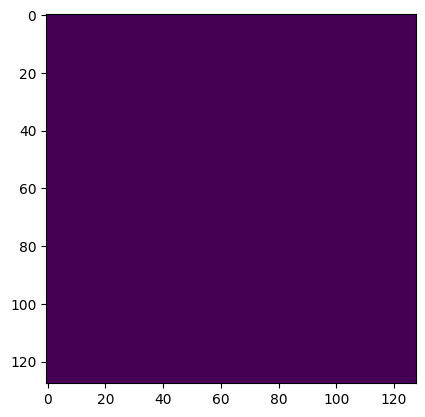

In [39]:
plt.imshow(label_tem[0,0,32].detach().cpu().numpy())

In [40]:
coordinate_map_np.shape

(105, 128, 128, 3)

In [41]:
pl = pv.Plotter(notebook=True)
interval = 1
if image_tem.shape[-3] > 20:
    interval = 5
if image_tem.shape[-3] > 256:
    interval = 10
for i in range(0, image_tem.shape[-3], interval):

    x, y, z = coordinate_map_np[i,...,0], coordinate_map_np[i,...,1], coordinate_map_np[i,...,2]

    grid = pv.StructuredGrid(x, y, z)

    color_gt = (label_tem[0,0,i].cpu().numpy().T.flatten() ==2).astype(np.float32)
    raw_image = image_tem[0,0,i].cpu().numpy().T.flatten()
    color_opacity = np.ones_like(color_gt)*0.4

    color_opacity[color_gt == 0] = 0.05

    pl.add_mesh(grid, scalars = color_gt, cmap = 'Accent_r',
                show_scalar_bar = False, opacity = color_opacity, clim=[0,3])
    
    

pl.add_mesh(lv_trimesh, color='blue', opacity=0.1)

# # pl.add_mesh(bi_ventricle_trimesh_target, color='red', opacity=0.1)
# pl.add_mesh(lv_trimesh_target, color='blue', opacity=0.2, show_edges=True, show_vertices=True)
# pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')

# pl.add_points(Pt_center.cpu().numpy(), color='red', point_size=10)
# pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(u2d_axis).cpu().numpy(), color='blue') 
# pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(l2r_axis).cpu().numpy(), color='green')
# pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(b2f_axis).cpu().numpy(), color='red')
pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')


pl.add_mesh(recubified_trimesh, color='red', opacity=0.1)


# pl.add_points(lv_cavity_center.cpu().numpy(), color='red', point_size=10)

pl.add_axes()
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [2]:
dataset =  ACDCDataset_Augmented(dataset_path='../../../Dataset/ACDC',mode='train', output_shape=(7, 128, 128))
# dataset = MMWHSDataset_Augmented(dataset_path='../../../Dataset/MMWHS',mode='train',modality='mixed',
#                                  rotation_range=[-np.pi, np.pi], scale_range=[0.9, 1.1], trans_range=[10., 10.], 
#                                  aug_dim=3,
#                                  output_shape=(64, 128, 128), RML_simple=True)

device = torch.device('cuda:0')

dataloaders = DataLoader(dataset, batch_size=1, shuffle=True)

query_num = 1000

## Constant rescacle ##
rescale = 1.0/100 # -1 to 1 = 200 mm

indx = 0
for i, example in enumerate(dataloaders):

    image_tem = example['image'].to(device)
    label_tem = example['label'].to(device)
    
    B, C, Z, Y, X = image_tem.shape

    affine_tem = example['affine'].to(device)
    affine_rand = dut.random_affine(B=B, dim=3, rot_range=[-np.pi, np.pi], 
                            trans_range=[-0.1, 0.1], scale_range=[1.0, 1.0]).to(device)
    
    affine_tem = torch.matmul(affine_rand, affine_tem)
    coordinate_map_tem = dut.get_coord_map_3d(image_tem.shape[-3:], affine_tem, rescaler=rescale).to(device)


    S = affine_tem[0,:3,:3].norm(dim=-2, keepdim=True)
    R = affine_tem[0,:3,:3]/S
    T = affine_tem[0,:3,3]/torch.tensor([X-1, Y-1, Z-1]).to(device).view(1,3)*2

    
    with torch.no_grad():

        ## generate the query points
        query_points_labeled = rearrange(coordinate_map_tem, 
                                            'b z y x c -> b (z y x) c', c=3)
        query_points_labeled = torch.cat([query_points_labeled, 
                                        rearrange(label_tem==dataset.label_value[2], 'b 1 z y x -> b (z y x) 1')], dim=-1)
        query_pts = torch.tensor([[0, 0, 0], [0, 0, Z-1], [0, Y-1, 0], [0, Y-1, Z-1], [X-1, 0, 0], [X-1, 0, Z-1], [X-1, Y-1, 0], [X-1, Y-1, Z-1]]).to(device)
        
        query_points_list = []
        target_affine_list = []
        for b in range(B):
            Z_rv, Y_rv, X_rv = torch.where(label_tem[b, 0]==dataset.label_value[1])
            Z_lv, Y_lv, X_lv = torch.where(label_tem[b, 0]==dataset.label_value[2])
            Z_cav, Y_cav, X_cav = torch.where(label_tem[b, 0]==dataset.label_value[3])
            Z_bg, Y_bg, X_bg = torch.where(label_tem[b, 0]==dataset.label_value[0])
            

            Pt_rv = coordinate_map_tem[b, Z_rv, Y_rv, X_rv]
            Pt_lv = coordinate_map_tem[b, Z_lv, Y_lv, X_lv]
            Pt_cav = coordinate_map_tem[b, Z_cav, Y_cav, X_cav]

            geom_dict = get_4chamberview_frame(Pt_cav, Pt_lv, Pt_rv)
            target_affine_list.append(geom_dict['target_affine'])

            # select the query points
            query_points_index_0 = torch.where(((query_points_labeled[b,:,:3]).abs().max(dim=-1).values < 1.0) & (query_points_labeled[b,:,3] < 0.5))[0]
            query_points_index_1 = torch.where(((query_points_labeled[b,:,:3]).abs().max(dim=-1).values < 1.0) & (query_points_labeled[b,:,3] > 0.5))[0]
            query_points_index_0 = query_points_index_0[np.random.choice(query_points_index_0.shape[0], query_num//2, replace=True)]
            query_points_index_1 = query_points_index_1[np.random.choice(query_points_index_1.shape[0], query_num//2, replace=True)]
            query_points_index = torch.cat([query_points_index_0, query_points_index_1], dim=0)
            query_points_list.append(query_points_labeled[b: b+1, query_points_index])

        query_points_labeled = torch.cat(query_points_list, dim=0)
        target_affine = torch.stack(target_affine_list, dim=0)


    if i==indx:
        break
    

coordinate_map_np = rearrange(coordinate_map_tem, '1 z y x d-> z y x d').detach().cpu().numpy()




Loading data from:  ../../../Dataset/ACDC/database/training/
Total number of loaded data:  200


/home/yihao/data/IC/IF-PINN/ops/medical_related.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  if u2d_axis@(Pt_center_lv-Pt_center).T < 0:


In [3]:
canonical_frame = torch.tensor([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]).T.float().to(device)
for b in range(B):
    with torch.no_grad():
        Z_rv, Y_rv, X_rv = torch.where(label_tem[b, 0]==dataset.label_value[1])
        Z_lv, Y_lv, X_lv = torch.where(label_tem[b, 0]==dataset.label_value[2])
        Z_cav, Y_cav, X_cav = torch.where(label_tem[b, 0]==dataset.label_value[3])
        Z_bg, Y_bg, X_bg = torch.where(label_tem[b, 0]==dataset.label_value[0])
        

        Pt_rv = coordinate_map_tem[b, Z_rv, Y_rv, X_rv]
        Pt_lv = coordinate_map_tem[b, Z_lv, Y_lv, X_lv]
        Pt_cav = coordinate_map_tem[b, Z_cav, Y_cav, X_cav]

        geom_dict = get_4chamberview_frame(Pt_cav, Pt_lv, Pt_rv)
        


 
        # R = torch.matmul(target_frame,canonical_frame.T)
        # T = Pt_center

        # target_affine = torch.eye(4).to(device)
        # target_affine[:3,:3] = R
        # target_affine[:3,3] = T

In [4]:
bi_ventricle_trimesh = trimesh.load_mesh('../canonical_shapes/Standard_BiV.obj')
lv_trimesh = trimesh.load_mesh('../canonical_shapes/Standard_LV_2000.obj')

In [5]:
target_affine = geom_dict['target_affine']
Pt_center = geom_dict['mean_cav']
Pt_center_lv = geom_dict['mean_lv']
Pt_center_rv = geom_dict['mean_rv']
b2f_axis = geom_dict['b2f_axis']
l2r_axis = geom_dict['l2r_axis']
u2d_axis = geom_dict['u2d_axis']
bi_ventricle_trimesh_target = bi_ventricle_trimesh.copy().apply_transform(target_affine.cpu().numpy())
lv_trimesh_target = lv_trimesh.copy().apply_transform(target_affine.cpu().numpy())

In [7]:
target_affine

tensor([[-0.9481,  0.2497, -0.1969, -0.0389],
        [ 0.0858, -0.3952, -0.9146, -0.0695],
        [-0.3062, -0.8840,  0.3533,  0.0361],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')

In [6]:
pl = pv.Plotter(notebook=True)
interval = 1
if image_tem.shape[-3] > 20:
    interval = 3
if image_tem.shape[-3] > 256:
    interval = 10
for i in range(0, image_tem.shape[-3], interval):

    x, y, z = coordinate_map_np[i,...,0], coordinate_map_np[i,...,1], coordinate_map_np[i,...,2]

    grid = pv.StructuredGrid(x, y, z)

    color_gt = label_tem[0,0,i].cpu().numpy().T.flatten()
    raw_image = image_tem[0,0,i].cpu().numpy().T.flatten()
    color_opacity = np.ones_like(color_gt)*0.2

    color_opacity[color_gt == 0] = 0.1

    pl.add_mesh(grid, scalars = color_gt, cmap = 'Accent_r',
                show_scalar_bar = False, opacity = color_opacity, clim=[0, 3])
    
    

# trimesh_lv = trimesh.Trimesh(vertices=mesh_lv.verts_list()[0].detach().cpu().numpy()/100, faces=mesh_lv.faces_list()[0].detach().cpu().numpy())
# simplified_mesh = trimesh_lv.simplify_quadratic_decimation(4000)
# trimesh.smoothing.filter_taubin(simplified_mesh, iterations=10)
# decimate the mesh
# pl.add_mesh(simplified_mesh, color='blue', opacity=0.1)

# pl.add_mesh(bi_ventricle_trimesh_target, color='red', opacity=0.1)
pl.add_mesh(lv_trimesh_target, color='blue', opacity=0.2, show_edges=True, show_vertices=True)
pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')

pl.add_points(Pt_center.cpu().numpy(), color='red', point_size=10)
pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(u2d_axis).cpu().numpy(), color='blue') 
pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(l2r_axis).cpu().numpy(), color='green')
pl.add_arrows(Pt_center.cpu().numpy(), 0.3*(b2f_axis).cpu().numpy(), color='red')

pl.add_axes()
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…